In [1]:
from math import sqrt
import os
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import seaborn as sns

warnings.filterwarnings(action='ignore', message='numpy.dtype size changed')
warnings.filterwarnings(action='ignore', message='compiletime version 3.5 of module')

if not 'workbookDir' in globals():
    workbookDir = os.getcwd()
os.chdir(os.path.split(workbookDir)[0])

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from synthesized.core import BasicSynthesizer, SeriesSynthesizer
from synthesized.core.values import CategoricalValue, ContinuousValue
from synthesized.testing.evaluation import Evaluation

os.getcwd()
evaluation = Evaluation(config_path='../synthesized/configs/evaluation/synthetic_distributions.json', name='synthetic')
#evaluation = Evaluation()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Copyright (C) Synthesized Ltd. - All Rights Reserved
License key: EE6B-6720-67A2-32F3-3139-2D31-322D-B531
Expires at: 2019-12-31 00:00:00


In [13]:
def edit_distance(seq, ref, categorical):
    assert len(seq) <= len(ref)
    distances = [0 for _ in range(len(ref) + 1)]
    for ny, y in enumerate(seq):
        next_distances = [ny + 1]
        for nx, x in enumerate(ref):
            if categorical:
                if x == y:
                    next_distances.append(distances[nx])
                else:
                    next_distances.append(min(
                        1 + distances[nx], 1 + distances[nx + 1],
                        min(d + next_distances[-d] for d in range(1, nx + 2))
                    ))
            else:
                next_distances.append(min(  # 2 because of sine so!!!
                    abs(x - y) + distances[nx], 2 + distances[nx + 1],
                    min(2 * d + next_distances[-d] for d in range(1, nx + 2))
                ))
        distances = next_distances
        yield min(distances[ny + 1:])

In [4]:
def plot_data(data, ax, value_types, series_length, target=None):
    assert 'x' in value_types
    if len(value_types) == 1:
        sns.lineplot(x=np.arange(series_length), y=data['x'][:series_length], ax=ax)
        if target is not None:
            ax2 = ax.twinx()
            distance = list(edit_distance(
                seq=data['x'], ref=target['x'],
                categorical=(value_types['x'] is CategoricalValue)
            ))
            sns.lineplot(x=np.arange(series_length), y=distance, ax=ax2, color='red')
    elif len(value_types) == 2:
        if 'id' in value_types:
            for i in data['id'].unique():
                sns.lineplot(x=np.arange(series_length), y=data[data['id'] == i]['x'][:series_length], ax=ax)
        elif 't' in value_types:
            sns.lineplot(x=data['t'][:series_length], y=data['x'][:series_length], ax=ax)
        else:
            assert False
    else:
        assert False

In [5]:
def synthesize_and_plot(
    data, lstm_mode, num_series=1, series_length=100, num_iterations=None
):
    if num_iterations is None:
        num_iterations = evaluation.config['num_iterations']
    start = time.time()
    with SeriesSynthesizer(
        data=data, lstm_mode=lstm_mode, identifier_label=('id' if 'id' in data else None),
        **evaluation.config['params']
    ) as synthesizer:
        print('value types:')
        for value in synthesizer.values:
            print(value.name, value)
        value_types = {value.name: type(value) for value in synthesizer.values}
        synthesizer.learn(data=data, num_iterations=num_iterations, verbose=250)  # , print_data=5)
        print('took', time.time() - start, 's')
        synthesized = synthesizer.synthesize(num_series=num_series, series_length=series_length)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('original')
        ax2.set_title('synthesized')
        plot_data(data, ax=ax1, value_types=value_types, series_length=series_length)
        plot_data(
            synthesized, ax=ax2, value_types=value_types, series_length=series_length,
            target=data
        )

## Time-series tests

### Single periodic categorical series

In [6]:
def create_periodic_categorical_series(length, period, num=1, max_period=None):
    assert length >= 1 and period > 0.0 and num >= 1
    assert max_period is None or max_period > period
    series = list()
    for _ in range(num):
        if max_period is None:
            p = period
        else:
            p = np.random.randint(period, max_period + 1)
        xs = np.arange(p)
        ys = np.concatenate([np.tile(xs, length // p), xs[:length % p]])
        series.append(ys)
    if num == 1:
        return pd.DataFrame({'x': series[0]})
    else:
        ids = [i for i in range(num) for _ in range(length)]
        series = np.concatenate(series)
        return pd.DataFrame({'id': ids, 'x': series})

In [7]:
data = create_periodic_categorical_series(length=1000, period=5)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
value types:
x categorical5-114

iteration: 1
loss: total=-1.39e+02 (encoding=13.412606239318848, x=-152.5300750732422, regularization=7.016683230176568e-05)
KS distances: avg=0.10 (x=0.10)

iteration: 125
loss: total=-1.50e+02 (encoding=2.5866751670837402, x=-152.1959686279297, regularization=8.186116610886529e-05)
KS distances: avg=0.00 (x=0.00)

iteration: 250
loss: total=-1.50e+02 (encoding=1.757506251335144, x=-151.35130310058594, regularization=8.990713831735775e-05)
KS distances: avg=0.00 (x=0.00)

iteration: 500
loss: total=-1.51e+02 (encoding=1.3800889253616333, x=-151.9434051513672, regularization=0.00010742382437456399)
KS distances: avg=0.02 (x=0.02)

iteration: 750
loss: total=-1.50e+02 (encoding=0.7704958319664001, x=-151.07264709472656, regularization=0.00013002261403016746)
KS distances: avg=0.01 (x=0.01)

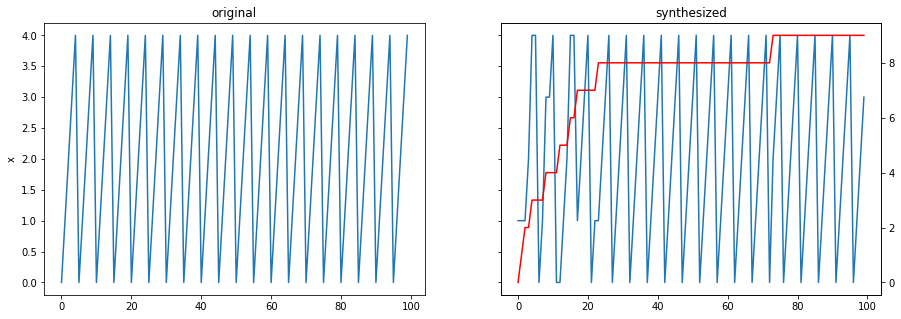

In [8]:
synthesize_and_plot(data, lstm_mode=1)

value types:
x categorical5-114

iteration: 1
loss: total=-1.52e+02 (encoding=0.013716251589357853, x=-152.4587860107422, regularization=7.019558688625693e-05)
KS distances: avg=0.22 (x=0.22)

iteration: 125
loss: total=-1.57e+02 (encoding=0.0021732172463089228, x=-157.31112670898438, regularization=7.297367847058922e-05)
KS distances: avg=0.08 (x=0.08)

iteration: 250
loss: total=-1.57e+02 (encoding=0.0009019489516504109, x=-157.33154296875, regularization=7.291119254659861e-05)
KS distances: avg=0.14 (x=0.14)

iteration: 500
loss: total=-1.57e+02 (encoding=0.00028974813176319003, x=-157.32791137695312, regularization=7.084431126713753e-05)
KS distances: avg=0.20 (x=0.20)

iteration: 750
loss: total=-1.57e+02 (encoding=0.0013840205501765013, x=-157.3380126953125, regularization=6.885643961140886e-05)
KS distances: avg=0.12 (x=0.12)

iteration: 1000
loss: total=-1.57e+02 (encoding=0.007051418535411358, x=-157.20187377929688, regularization=7.039210322545841e-05)
KS distances: avg=0.09 

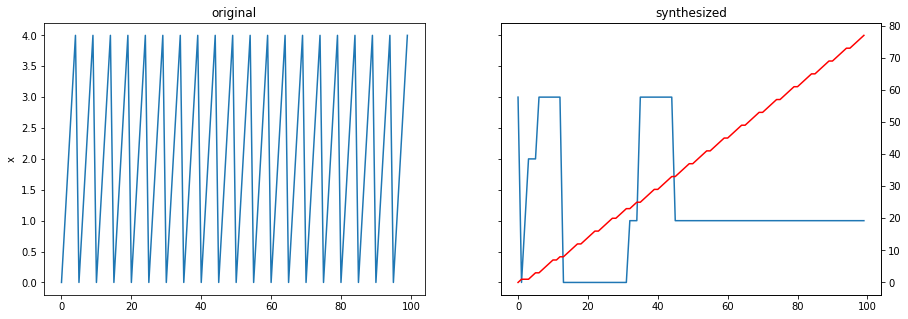

In [9]:
synthesize_and_plot(data, lstm_mode=2)

In [10]:
data = create_periodic_categorical_series(length=1000, period=20)

value types:
x categorical20-194-similarity

iteration: 1
loss: total=-2.55e+02 (encoding=13.509934425354004, x=-268.7615966796875, regularization=9.301237878389657e-05)
KS distances: avg=0.15 (x=0.15)

iteration: 125
loss: total=-2.65e+02 (encoding=2.9103753566741943, x=-267.91943359375, regularization=0.00011751677811844274)
KS distances: avg=0.03 (x=0.03)

iteration: 250
loss: total=-2.61e+02 (encoding=4.051846981048584, x=-264.6569519042969, regularization=0.00013690063497051597)
KS distances: avg=0.02 (x=0.02)

iteration: 500
loss: total=-2.58e+02 (encoding=4.646452903747559, x=-262.2298889160156, regularization=0.0001682183356024325)
KS distances: avg=0.02 (x=0.02)

iteration: 750
loss: total=-2.59e+02 (encoding=3.9679367542266846, x=-262.5557861328125, regularization=0.00019419481395743787)
KS distances: avg=0.02 (x=0.02)

iteration: 1000
loss: total=-2.58e+02 (encoding=4.316427230834961, x=-262.2040100097656, regularization=0.0002131199580617249)
KS distances: avg=0.02 (x=0.02)

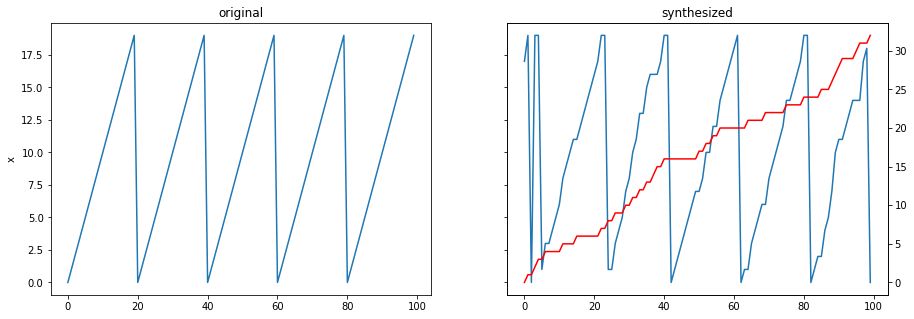

In [11]:
synthesize_and_plot(data, lstm_mode=1)

value types:
x categorical20-194-similarity

iteration: 1
loss: total=-2.69e+02 (encoding=0.013560366816818714, x=-268.7647705078125, regularization=9.264486288884655e-05)
KS distances: avg=0.33 (x=0.33)

iteration: 125
loss: total=-2.78e+02 (encoding=0.049019817262887955, x=-278.22314453125, regularization=0.00011345973325660452)
KS distances: avg=0.04 (x=0.04)

iteration: 250
loss: total=-2.69e+02 (encoding=0.0562286414206028, x=-269.0335693359375, regularization=0.00012793215864803642)
KS distances: avg=0.02 (x=0.02)

iteration: 500
loss: total=-2.62e+02 (encoding=0.06408427655696869, x=-262.3920593261719, regularization=0.00015336606884375215)
KS distances: avg=0.01 (x=0.01)

iteration: 750
loss: total=-2.74e+02 (encoding=0.06014744192361832, x=-274.0721740722656, regularization=0.00017816477338783443)
KS distances: avg=0.02 (x=0.02)

iteration: 1000
loss: total=-2.61e+02 (encoding=0.0733497366309166, x=-260.8052978515625, regularization=0.00019491984858177602)
KS distances: avg=0.

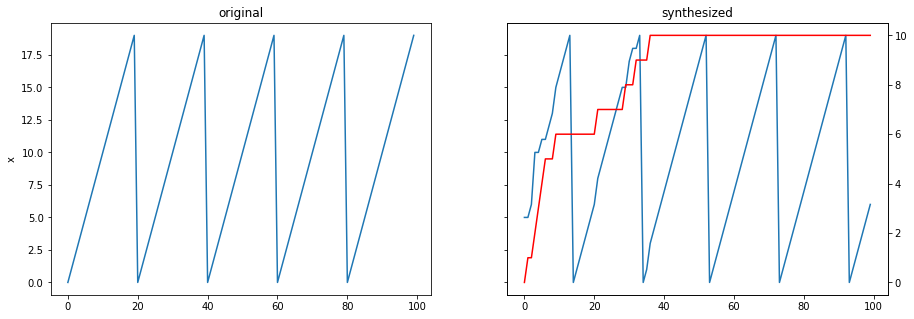

In [14]:
synthesize_and_plot(data, lstm_mode=2)

### Multiple periodic categorical series

In [15]:
data = create_periodic_categorical_series(length=100, period=5, max_period=20, num=10)

value types:
id identifier10-256
x categorical20-194-similarity

iteration: 1
loss: total=4.83e+00 (encoding=1.3447920083999634, x=3.489542007446289, regularization=9.312515612691641e-05)
KS distances: avg=0.54 (x=0.54)

iteration: 125
loss: total=-1.72e+01 (encoding=0.27487465739250183, x=-17.494991302490234, regularization=0.00010950306023005396)
KS distances: avg=0.40 (x=0.40)

iteration: 250
loss: total=-1.78e+01 (encoding=0.4647693634033203, x=-18.309722900390625, regularization=0.0001356117136310786)
KS distances: avg=0.32 (x=0.32)

iteration: 500
loss: total=-1.98e+01 (encoding=0.5139937400817871, x=-20.359386444091797, regularization=0.00018048725905828178)
KS distances: avg=0.29 (x=0.29)

iteration: 750
loss: total=-2.18e+01 (encoding=0.3579762876033783, x=-22.151832580566406, regularization=0.00021704220853280276)
KS distances: avg=0.35 (x=0.35)

iteration: 1000
loss: total=-1.81e+01 (encoding=0.49366694688796997, x=-18.556880950927734, regularization=0.00024082815798465163)


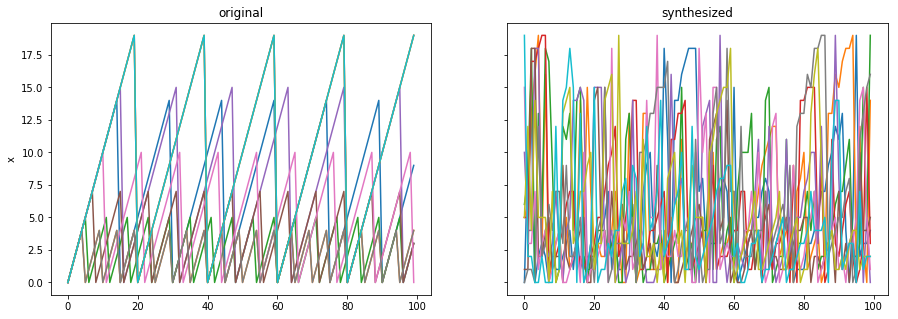

In [16]:
synthesize_and_plot(data, lstm_mode=1, num_series=10)

value types:
id identifier10-256
x categorical20-194-similarity

iteration: 1
loss: total=-1.08e+01 (encoding=0.013247855938971043, x=-10.847589492797852, regularization=9.284533734899014e-05)
KS distances: avg=0.62 (x=0.62)

iteration: 125
loss: total=-1.69e+01 (encoding=0.0013961902586743236, x=-16.867645263671875, regularization=0.00010036645835498348)
KS distances: avg=0.65 (x=0.65)

iteration: 250
loss: total=-1.33e+01 (encoding=0.009528405033051968, x=-13.260076522827148, regularization=0.00012000690185232088)
KS distances: avg=0.75 (x=0.75)

iteration: 500
loss: total=-1.50e+01 (encoding=0.009904651902616024, x=-14.976741790771484, regularization=0.00017796290921978652)
KS distances: avg=0.61 (x=0.61)

iteration: 750
loss: total=-1.83e+01 (encoding=0.013228134252130985, x=-18.355443954467773, regularization=0.00020957511151209474)
KS distances: avg=0.45 (x=0.45)

iteration: 1000
loss: total=-2.03e+01 (encoding=0.02356230467557907, x=-20.301483154296875, regularization=0.00024956

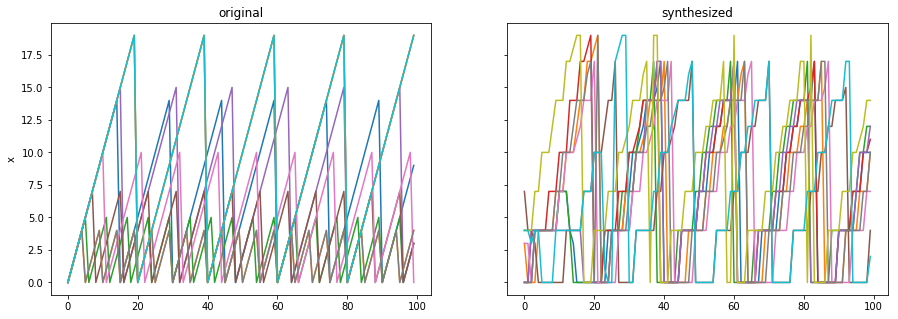

In [17]:
synthesize_and_plot(data, lstm_mode=2, num_series=10)

### Single sine series

In [18]:
def create_sine_series(length, period, num=1, max_period=None):
    assert length >= 1 and period > 0.0 and num >= 1
    assert max_period is None or max_period > period
    series = list()
    for _ in range(num):
        if max_period is None:
            p = period
        else:
            p = period + np.random.random_sample() * (max_period - period)
        xs = np.arange(length)
        ys = np.sin(xs * np.pi * 2.0 / p)
        series.append(ys)
    if num == 1:
        return pd.DataFrame({'x': series[0]})
    else:
        ids = [i for i in range(num) for _ in range(length)]
        series = np.concatenate(series)
        return pd.DataFrame({'id': ids, 'x': series})

In [19]:
data = create_sine_series(length=1000, period=5.0)

value types:
x continuous-log_normal

iteration: 1
loss: total=1.43e+01 (encoding=13.306160926818848, x=1.0336616039276123, regularization=4.9450358346803114e-05)
KS distances: avg=0.40 (x=0.40)

iteration: 125
loss: total=2.31e+00 (encoding=2.2165629863739014, x=0.09221912920475006, regularization=6.704022234771401e-05)
KS distances: avg=0.16 (x=0.16)

iteration: 250
loss: total=1.78e+00 (encoding=1.7065635919570923, x=0.07136885821819305, regularization=7.516537880292162e-05)
KS distances: avg=0.15 (x=0.15)

iteration: 500
loss: total=8.55e-01 (encoding=0.8506082892417908, x=0.004604587331414223, regularization=9.038404823513702e-05)
KS distances: avg=0.14 (x=0.14)

iteration: 750
loss: total=5.76e-01 (encoding=0.5679988265037537, x=0.0074541703797876835, regularization=9.992318518925458e-05)
KS distances: avg=0.14 (x=0.14)

iteration: 1000
loss: total=9.59e-01 (encoding=0.9546313285827637, x=0.004694515373557806, regularization=0.00011093656939920038)
KS distances: avg=0.15 (x=0.15)

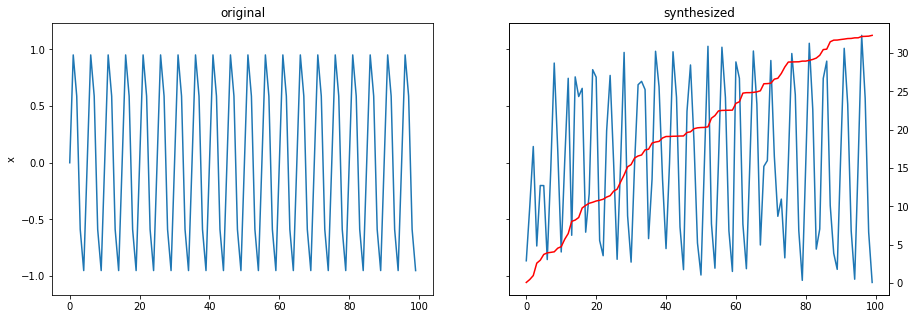

In [20]:
synthesize_and_plot(data, lstm_mode=1)

value types:
x continuous-log_normal

iteration: 1
loss: total=9.94e-01 (encoding=0.013770840130746365, x=0.9803820252418518, regularization=4.9198999477084726e-05)
KS distances: avg=0.55 (x=0.55)

iteration: 125
loss: total=9.84e-01 (encoding=0.0028084160294383764, x=0.9809791445732117, regularization=5.329781197360717e-05)
KS distances: avg=0.59 (x=0.59)

iteration: 250
loss: total=9.81e-01 (encoding=0.003186399582773447, x=0.9780238270759583, regularization=5.781467189081013e-05)
KS distances: avg=0.57 (x=0.57)

iteration: 500
loss: total=1.02e+00 (encoding=0.010767482221126556, x=1.0094841718673706, regularization=6.862657028250396e-05)
KS distances: avg=0.56 (x=0.56)

iteration: 750
loss: total=1.36e+00 (encoding=0.032733749598264694, x=1.324326515197754, regularization=0.00010553586616879329)
KS distances: avg=0.36 (x=0.36)

iteration: 1000
loss: total=1.82e+00 (encoding=0.037103720009326935, x=1.785080909729004, regularization=0.0001301070733461529)
KS distances: avg=0.18 (x=0.1

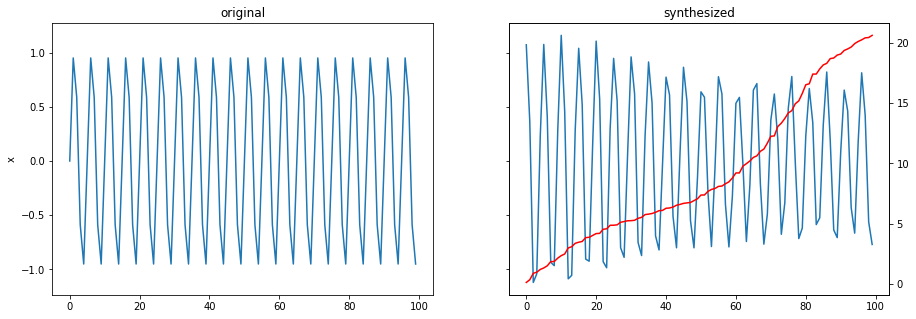

In [21]:
synthesize_and_plot(data, lstm_mode=2)

In [22]:
data = create_sine_series(length=1000, period=20.0)

value types:
x continuous-log_normal

iteration: 1
loss: total=1.43e+01 (encoding=13.369526863098145, x=0.9800510406494141, regularization=4.907185211777687e-05)
KS distances: avg=0.45 (x=0.45)

iteration: 125
loss: total=1.02e+00 (encoding=0.9351704716682434, x=0.08120676875114441, regularization=6.227774429135025e-05)
KS distances: avg=0.16 (x=0.16)

iteration: 250
loss: total=6.63e-01 (encoding=0.6081559062004089, x=0.05431066080927849, regularization=6.755504728062078e-05)
KS distances: avg=0.11 (x=0.11)

iteration: 500
loss: total=8.73e-01 (encoding=0.7876737117767334, x=0.08550857752561569, regularization=7.482196087948978e-05)
KS distances: avg=0.09 (x=0.09)

iteration: 750
loss: total=7.48e-01 (encoding=0.6940298080444336, x=0.05352882295846939, regularization=8.065342262852937e-05)
KS distances: avg=0.10 (x=0.10)

iteration: 1000
loss: total=6.95e-01 (encoding=0.6633307933807373, x=0.031610120087862015, regularization=8.68736970005557e-05)
KS distances: avg=0.09 (x=0.09)
took 

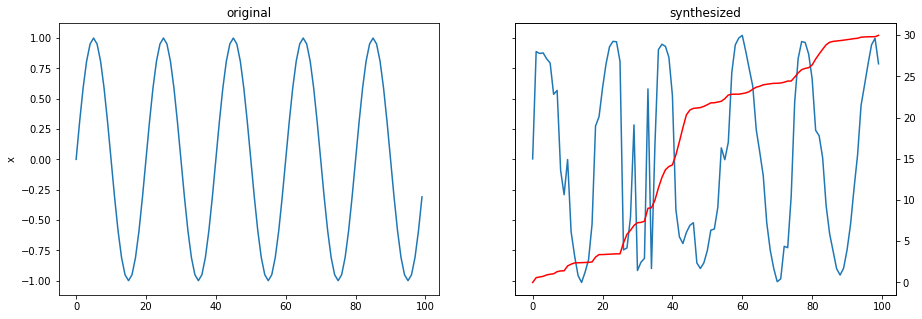

In [23]:
synthesize_and_plot(data, lstm_mode=1)

value types:
x continuous-normal

iteration: 1
loss: total=1.03e+00 (encoding=0.014031968079507351, x=1.0149855613708496, regularization=4.9440575821790844e-05)
KS distances: avg=0.45 (x=0.45)

iteration: 125
loss: total=1.49e+00 (encoding=0.031227929517626762, x=1.4543124437332153, regularization=5.598998541245237e-05)
KS distances: avg=0.33 (x=0.33)

iteration: 250
loss: total=2.30e+00 (encoding=0.03598028048872948, x=2.2645912170410156, regularization=6.296766514424235e-05)
KS distances: avg=0.11 (x=0.11)

iteration: 500
loss: total=7.59e-01 (encoding=0.03214244171977043, x=0.7265391945838928, regularization=6.649231363553554e-05)
KS distances: avg=0.09 (x=0.09)

iteration: 750
loss: total=7.26e-01 (encoding=0.032865259796381, x=0.6929829120635986, regularization=6.899206346133724e-05)
KS distances: avg=0.09 (x=0.09)

iteration: 1000
loss: total=2.00e+00 (encoding=0.028811998665332794, x=1.9747830629348755, regularization=7.082348747644573e-05)
KS distances: avg=0.09 (x=0.09)
took 1

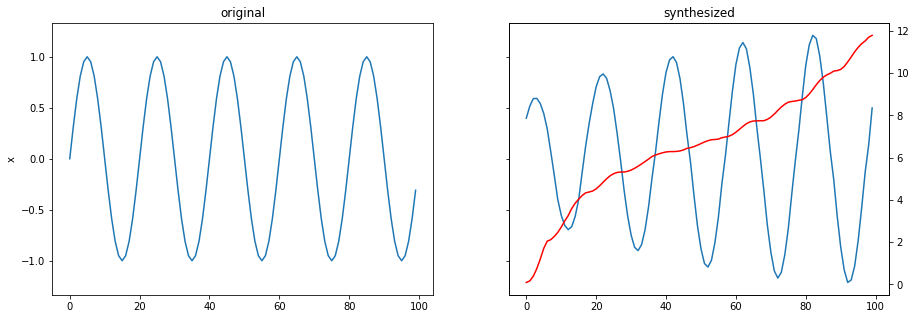

In [24]:
synthesize_and_plot(data, lstm_mode=2)

### Multiple sine series

In [25]:
data = create_sine_series(length=100, period=5.0, max_period=20.0, num=10)

value types:
id identifier10-256
x continuous-normal

iteration: 1
loss: total=2.35e+00 (encoding=1.339712381362915, x=1.00766122341156, regularization=4.9129674152936786e-05)
KS distances: avg=0.48 (x=0.48)

iteration: 125
loss: total=2.89e-01 (encoding=0.20375508069992065, x=0.08536434918642044, regularization=6.375090742949396e-05)
KS distances: avg=0.11 (x=0.11)

iteration: 250
loss: total=3.03e-01 (encoding=0.18537482619285583, x=0.11793338507413864, regularization=6.930586823727936e-05)
KS distances: avg=0.11 (x=0.11)

iteration: 500
loss: total=2.63e-01 (encoding=0.12740272283554077, x=0.1353205144405365, regularization=7.753881072858348e-05)
KS distances: avg=0.12 (x=0.12)

iteration: 750
loss: total=2.43e-01 (encoding=0.1362442523241043, x=0.10679574310779572, regularization=8.521830750396475e-05)
KS distances: avg=0.12 (x=0.12)

iteration: 1000
loss: total=1.68e-01 (encoding=0.14120885729789734, x=0.026349661871790886, regularization=9.091584070120007e-05)
KS distances: avg=0

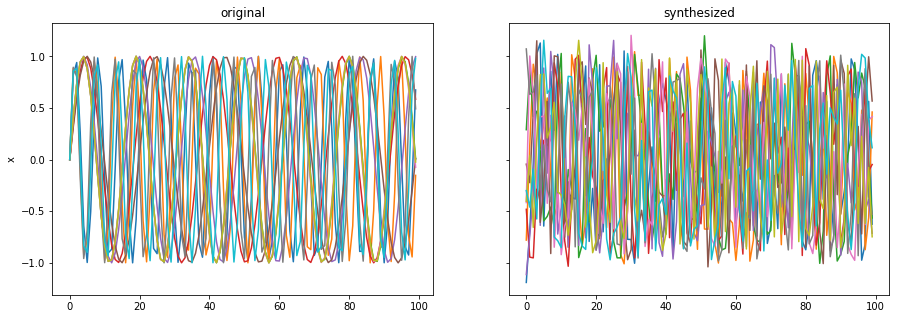

In [26]:
synthesize_and_plot(data, lstm_mode=1, num_series=10)

value types:
id identifier10-256
x continuous-normal

iteration: 1
loss: total=9.91e-01 (encoding=0.01381848007440567, x=0.9767602682113647, regularization=4.945908585796133e-05)
KS distances: avg=0.47 (x=0.47)

iteration: 125
loss: total=9.96e-01 (encoding=0.00788701418787241, x=0.9881212115287781, regularization=5.391831655288115e-05)
KS distances: avg=0.47 (x=0.47)

iteration: 250
loss: total=1.01e+00 (encoding=0.004976058844476938, x=1.0004078149795532, regularization=5.7435296184848994e-05)
KS distances: avg=0.44 (x=0.44)

iteration: 500
loss: total=1.01e+00 (encoding=0.0021159278694540262, x=1.0078164339065552, regularization=6.435002433136106e-05)
KS distances: avg=0.45 (x=0.45)

iteration: 750
loss: total=1.01e+00 (encoding=0.008601296693086624, x=1.0022298097610474, regularization=7.80100526753813e-05)
KS distances: avg=0.44 (x=0.44)

iteration: 1000
loss: total=1.12e+00 (encoding=0.0075092618353664875, x=1.1111690998077393, regularization=9.052848326973617e-05)
KS distances: 

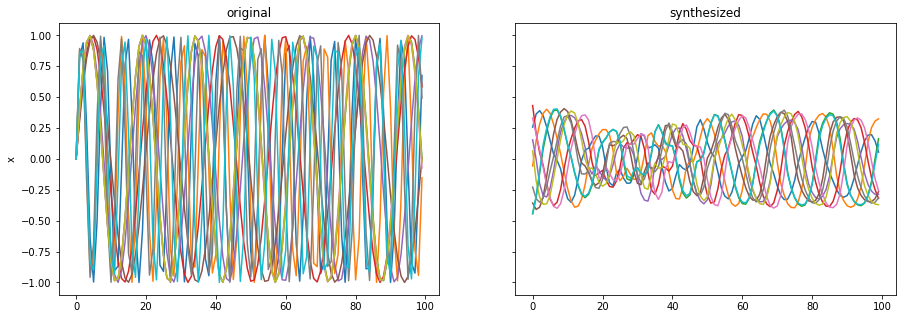

In [27]:
synthesize_and_plot(data, lstm_mode=2, num_series=10)

### Advanced

In [ ]:
def create_time_series_data(func, length):
    """
    Create a data frame of a time-series based on a time-series 
    function.
    
    :param func: {times: np.array[int]} -> np.array[float]]
                a function that takes a sequence of time steps and noise 
                and returns a series of values
    :param length: [int] number of time steps
    :return: pd.DataFrame{t[datetime], x[float]}
    """
    # create time columns
    times = np.arange(start=0, stop=length)
    
    # create value column
    xs = func(times)
    
    # cast times to date-time
    times = pd.to_datetime(times, unit="d")
    
    # combine
    df = pd.DataFrame({"t": times, "x": xs})
    return df

In [ ]:
def additive_linear(a, b, sd):
    """
    A linear trend with additive noise
    :param a: [float] slope
    :param b: [float] intercept
    :param sd: [float] error standard deviation
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*times + b + eps
    return out_func


def additive_sine(a, p, sd):
    """
    A sinusoidal trend with additive noise
    :param a: [float] amplitude
    :param p: [float] period
    :param sd: [float] error standard deviation
    """
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        return a*np.sin(2*np.pi*times/p) + eps
    return out_func


def auto_regressive(phi, c, sd):
    """
    A linear autoregressive process of order k 
    i.e an AR(k) process
    :param phi: [np.array] regression weights
    :param c: [float] bias
    :param sd: [float] error standard deviation
    """
    k = phi.shape[0]
    
    def out_func(times):
        eps = sd*np.random.randn(times.shape[0])
        out_list = k*[0.]
        for i in range(times.shape[0]):
            # fetch regression context: previous k values
            x_prev = np.array(out_list[-k:][::-1])
            # sample next value
            x_t = c + (phi*x_prev).sum() + eps[i]
            out_list.append(x_t)
        return out_list[k:]
    return out_func


def add_series(*args):
    """
    Return a time series which is a sum of 
    several other time series.
    :param args: times series closures
    :return: time series closure
    """
    def out_func(times):
        series = [func(times) for func in args]
        return sum(series)
    return out_func

In [ ]:
def rolling_mse_asof(data, synthesized, sd, time_unit=None):
    """
    Calculate the mean-squared error between the "x" values of the original and synthetic 
    data. The sets of times may not be identical so we use "as of" (last observation rolled 
    forward) to interpolate between the times in the two datasets.
    
    The dates are also optionally truncated to some unit following the syntax for the pandas 
    `.floor` function.
    
    :param data: [pd.DataFrame{id[int], t[datetime], x[float]}] original data
    :param synthesized: [pd.DataFrame{id[int], t[datetime], x[float]}] synthesized data
    :param sd: [float] error standard deviation
    :param time_unit: [str] the time unit to round to. See documentation for pandas `.floor` method.
    :return: [(float, float)] MSE and MSE/(2*error variance) 
    """
    # truncate date 
    if time_unit is not None:
        synthesized.t = synthesized.t.dt.floor(time_unit)
        data.t = data.t.dt.floor(time_unit)
    
    # join datasets
    joined = pd.merge_asof(data[["t", "x"]], synthesized[["t", "x"]], on="t")
    
    # calculate metrics
    mse = ((joined.x_x - joined.x_y)**2).mean()
    mse_eff = mse/(2*sd**2)
    
    return mse, mse_eff

In [ ]:
def series_synthesize_and_plot(
    data, name, lstm_mode, num_series, sd, time_unit, series_length=100,
    identifier_label=None, num_iterations=None
):
    if num_iterations is None:
        num_iterations = evaluation.config['num_iterations']
    start = time.time()
    with SeriesSynthesizer(
        data=data, identifier_label=identifier_label, lstm_mode=lstm_mode, **evaluation.config['params']
    ) as synthesizer:
        print('value types:')
        for value in synthesizer.values:
            print(value.name, value)
        value_types = {value.name: type(value) for value in synthesizer.values}
        synthesizer.learn(data=data, num_iterations=num_iterations, verbose=250, print_data=5)
        print('took', time.time() - start, 's')
        synthesized = synthesizer.synthesize(num_series=1, series_length=len(data))
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)
        ax1.set_title('original')
        ax2.set_title('synthesized')
        plot_data(data, ax=ax1, value_types=value_types, series_length=series_length)
        plot_data(synthesized, ax=ax2, value_types=value_types, series_length=series_length)
        mse, mse_eff = rolling_mse_asof(data, synthesized, sd=sd, time_unit=time_unit)
        evaluation[f"{name}_mse"] = mse
        evaluation[f"{name}_mse_efficiency"] = mse_eff

In [ ]:
data = create_time_series_data(func=additive_linear(a=2., b=5., sd=1e-3), length=10000)

In [ ]:
series_synthesize_and_plot(data, "trend_linear_mode1", lstm_mode=1, num_series=1, sd=1.0, time_unit="d")

In [ ]:
series_synthesize_and_plot(
    data, "trend_linear_mode2", lstm_mode=2, num_series=1, sd=1.0, time_unit="d"
)

In [ ]:
data = create_time_series_data(func=additive_sine(a=10, p=1000, sd=1.), length=10000)

In [ ]:
series_synthesize_and_plot(
    data, name="cyclical_sinusoidal_mode1", lstm_mode=1, num_series=1, sd=1., time_unit="d"
)

In [ ]:
series_synthesize_and_plot(
    data, name="cyclical_sinusoidal_mode2", lstm_mode=2, num_series=1, sd=1., time_unit="d"
)

In [ ]:
data = create_time_series_data(
    func=add_series(additive_sine(a=20, p=1000, sd=5.), additive_sine(a=5, p=200, sd=1.)),
    length=10000
)

In [ ]:
series_synthesize_and_plot(
    data, name='cyclical_and_seasonal_sinusoidal_mode1', lstm_mode=1,
    num_series=1, sd=sqrt(1.**2 + 5**2), time_unit="d"
)

In [ ]:
series_synthesize_and_plot(
    data, name='cyclical_and_seasonal_sinusoidal_mode2', lstm_mode=2,
    num_series=1, sd=sqrt(1.0 ** 2 + 5**2), time_unit="d"
)